In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-13 10:16:22--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)...151.101.184.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.184.133|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.09s   

2020-05-13 10:16:22 (776 KB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



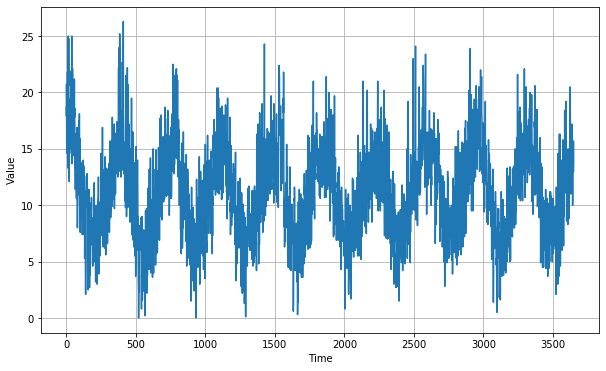

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader) # skip header row 
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, 
                         strides = 1, padding = 'causal', 
                         activation = 'relu', 
                         input_shape = [None, 1]), 
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(30, activation='relu'), 
  tf.keras.layers.Dense(30, activation='relu'), 
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 3s 300ms/step - loss: 16.8712 - mae: 17.4046
Epoch 2/100
10/10 [==============================] - 1s 80ms/step - loss: 16.5511 - mae: 17.0042
Epoch 3/100
10/10 [==============================] - 1s 80ms/step - loss: 15.9937 - mae: 16.4594
Epoch 4/100
10/10 [==============================] - 1s 82ms/step - loss: 15.4373 - mae: 15.9066
Epoch 5/100
10/10 [==============================] - 1s 80ms/step - loss: 14.9535 - mae: 15.3694
Epoch 6/100
10/10 [==============================] - 1s 81ms/step - loss: 14.4152 - mae: 14.8471
Epoch 7/100
10/10 [==============================] - 1s 80ms/step - loss: 13.8866 - mae: 14.3291
Epoch 8/100
10/10 [==============================] - 1s 80ms/step - loss: 13.3455 - mae: 13.7937
Epoch 9/100
10/10 [==============================] - 1s 80ms/step - loss: 12.7829 - mae: 13.2300
Epoch 10/100
10/10 [====

KeyboardInterrupt: 

[1e-08, 0.0001, 0, 60]

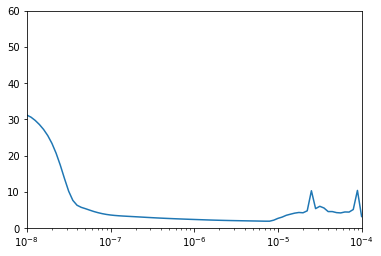

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 25, min_delta=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', patience = 10, min_delta=1e-4)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=500, 
                    callbacks = [early_stopping, reduce_lr])
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
10/10 [==============================] - 0s 40ms/step - loss: 1.7026 - mae: 2.1519 - lr: 1.0000e-05
Epoch 2/500
10/10 [==============================] - 1s 52ms/step - loss: 1.7028 - mae: 2.1521 - lr: 1.0000e-05
Epoch 3/500
10/10 [==============================] - 1s 54ms/step - loss: 1.7019 - mae: 2.1511 - lr: 1.0000e-05
Epoch 4/500
10/10 [==============================] - 1s 54ms/step - loss: 1.7014 - mae: 2.1506 - lr: 1.0000e-05
Epoch 5/500
10/10 [==============================] - 1s 51ms/step - loss: 1.7008 - mae: 2.1502 - lr: 1.0000e-05
Epoch 6/500
10/10 [==============================] - 1s 53ms/step - loss: 1.7006 - mae: 2.1499 - lr: 1.0000e-05
Epoch 7/500
10/10 [==============================] - 1s 53ms/step - loss: 1.6999 - mae: 2.1491 - lr: 1.0000e-05
Epoch 8/500
10/10 [==============================] - 1s 54ms/step - loss: 1.6990 - mae: 2.1483 - lr: 1.0000e-05
Epoch 9/500
10/10 [==============================] - 0s 50ms/step - loss: 1.6986 - mae: 2.1479 - lr: 1.0

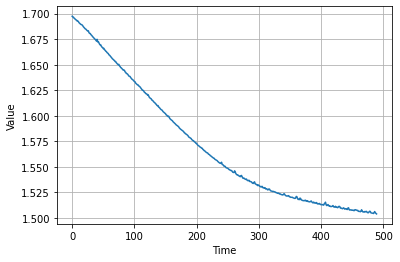

In [25]:
loss = history.history['loss'][10:]

plot_series(range(len(loss)), loss)

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

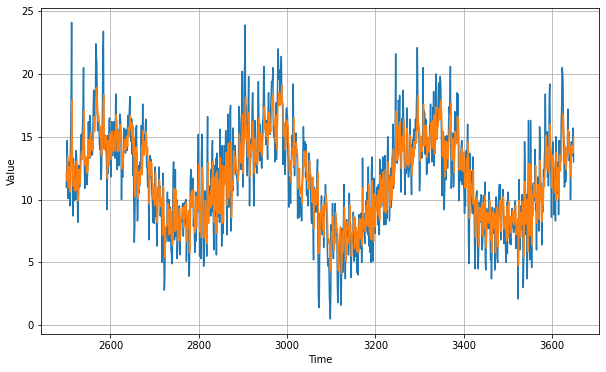

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7853283

In [29]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.057363 11.534016 12.443134 ... 13.717948 13.715853 14.972001]
